In [3]:
"""
!pip install --no-cache-dir --force-reinstall facenet-pytorch
"""
# Then import
from facenet_pytorch import InceptionResnetV1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ImportError: cannot import name 'is_directory' from 'PIL._util' (/usr/local/lib/python3.12/dist-packages/PIL/_util.py)

In [2]:
from facenet_pytorch import InceptionResnetV1

In [1]:
import kagglehub

import torch

from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import os
import cv2
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [3]:
def smart_face_crop(img, target_size=224):
    """
    Smart crop that biases toward upper portion for portrait images
    (where faces are usually located)
    """
    h, w = img.shape[:2]

    if h > w:
        # Portrait orientation - face is likely in upper portion
        crop_size = w  # Use width as crop size

        # Instead of centering vertically, bias toward top
        # Place crop so face (assumed to be in upper 40% of image) is centered in crop
        y_start = int(h * 0.15)  # Start at 15% from top

        # Make sure we don't go out of bounds
        if y_start + crop_size > h:
            y_start = h - crop_size

        x_start = 0  # Full width

    elif w > h:
        # Landscape orientation - face is likely in center horizontally
        crop_size = h  # Use height as crop size

        x_start = (w - crop_size) // 2  # Center horizontally
        y_start = 0  # Full height

    else:
        # Square image - just center crop
        crop_size = min(h, w)
        y_start = (h - crop_size) // 2
        x_start = (w - crop_size) // 2

    # Crop
    img_cropped = img[y_start:y_start+crop_size, x_start:x_start+crop_size]

    # Resize
    img_resized = cv2.resize(img_cropped, (target_size, target_size))

    return img_resized

In [7]:



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================
# STEP 2: LOAD YOUR DATA
# ============================================================

path = kagglehub.dataset_download("tapakah68/facial-emotion-recognition")

image_data_with_person = []
person_to_indices = defaultdict(list)
idx = 0

print("Loading images...")
for root, dirs, files in os.walk(path):
    folder_name = os.path.basename(root)
    if not folder_name.isdigit():
        continue
    person_id = folder_name

    for file in files:
        if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        file_path = os.path.join(root, file)
        img = cv2.imread(file_path)
        if img is None:
            continue

        emotion = os.path.splitext(file)[0]

        # Resize to 224×224 (ResNet standard input size)
        img_resized = smart_face_crop(img, target_size=224)  # ← ResNet uses 224×224!

        # IMPORTANT: Keep as RGB (3 channels) for ResNet
        # Don't convert to grayscale!
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        image_data_with_person.append({
            'image': img_rgb,  # RGB, not grayscale
            'emotion': emotion,
            'person': person_id,
            'index': idx
        })

        person_to_indices[person_id].append(idx)
        idx += 1

print(f"Loaded {len(image_data_with_person)} images")

# ============================================================
# STEP 3: PERSON-INDEPENDENT SPLIT
# ============================================================

people = list(person_to_indices.keys())
np.random.seed(42)
np.random.shuffle(people)

n_train_people = int(0.8 * len(people))
train_people = set(people[:n_train_people])
test_people = set(people[n_train_people:])

print(f"Train people: {sorted(train_people, key=int)}")
print(f"Test people: {sorted(test_people, key=int)}")

# Split data
train_images, train_labels = [], []
test_images, test_labels = [], []

for item in image_data_with_person:
    if item['person'] in train_people:
        train_images.append(item['image'])
        train_labels.append(item['emotion'])
    else:
        test_images.append(item['image'])
        test_labels.append(item['emotion'])

# Encode labels
le = LabelEncoder()
all_emotions = [item['emotion'] for item in image_data_with_person]
le.fit(all_emotions)
train_labels_encoded = le.transform(train_labels)
test_labels_encoded = le.transform(test_labels)

print(f"\nTrain: {len(train_images)} images")
print(f"Test: {len(test_images)} images")
print(f"Classes: {list(le.classes_)}")


# ============================================================
# STEP 4: DEFINE TRANSFORMS
# ============================================================
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# ============================================================
# STEP 5: CREATE DATASET WITH PROPER TRANSFORMS
# ============================================================

class EmotionDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: list of numpy arrays (H, W, 3) - RGB images
        labels: numpy array of labels
        transform: torchvision transforms
        """
        self.images = images  # List of RGB numpy arrays
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # (224, 224, 3) numpy array
        label = self.labels[idx]

        # Convert to PIL Image
        image_pil = Image.fromarray(image.astype(np.uint8))

        # Apply transforms
        if self.transform:
            image = self.transform(image_pil)
        else:
            image = transforms.ToTensor()(image_pil)

        return image, label




# ============================================================
# STEP 6: CREATE DATASETS AND DATALOADERS
# ============================================================
train_dataset = EmotionDataset(train_images, train_labels_encoded, transform=train_transform)
test_dataset = EmotionDataset(test_images, test_labels_encoded, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")




# ============================================================
# STEP 7: Create Model
# ============================================================

# Load face-pretrained model
model = InceptionResnetV1(
    pretrained='vggface2',  # Pre-trained on faces
    classify=False           # Remove original classifier
)

# Add emotion classifier
model.logits = nn.Linear(512, 8)  # 8 emotions
model = model.to(device)

print("✅ Model loaded!")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


# ============================================================
# STEP 8: CHOOSE TRAINING STRATEGY
# ============================================================

print("\n" + "="*60)
print("TRAINING STRATEGY")
print("="*60)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)


# ============================================================
# STEP 9: EVALUATION FUNCTION
# ============================================================

def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ============================================================
# STEP 10: TRAINING FUNCTION
# ============================================================

def train_transfer_learning(model, epochs, train_loader, test_loader,
                            criterion, optimizer, scheduler, device=None, patience=15):
    import time
    best_test_acc = 0
    patience_counter = 0
    train_losses = []
    test_losses = []  # ✅ Already declared
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    for epoch in range(epochs):
        # ============ TRAINING ============
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ============ EVALUATION ============
        # Calculate test loss
        model.eval()
        test_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

        avg_test_loss = test_running_loss / len(test_loader)
        test_losses.append(avg_test_loss)  # ✅ Now tracking test loss!

        # Calculate accuracies
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc = evaluate_accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Learning rate scheduling
        scheduler.step(test_acc)

        # ============ PRINT PROGRESS ============
        if (epoch + 1) % 5 == 0 or epoch == 0:
            elapsed = time.time() - start_time
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d}/{epochs} - "
                  f"Train Loss: {avg_train_loss:.3f} - "
                  f"Test Loss: {avg_test_loss:.3f} - "  # ✅ Added
                  f"Train Acc: {train_acc:5.2f}% - "
                  f"Test Acc: {test_acc:5.2f}% - "
                  f"LR: {current_lr:.6f} - "
                  f"Time: {elapsed/60:.1f}min")

        # ============ EARLY STOPPING ============
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_resnet_model.pth')
            print(f"  ✓ New best: {best_test_acc:.2f}%")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\n⚠️ Early stopping at epoch {epoch+1}")
            break

    # ============ LOAD BEST MODEL ============
    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETE")
    print(f"{'='*60}")
    print(f"Best test accuracy: {best_test_acc:.2f}%")
    print(f"Total time: {total_time/60:.1f} minutes")

    # ✅ Return all 4 metrics as a dictionary
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

# ============================================================
# STEP 11: TRAIN!
# ============================================================

results = train_transfer_learning(
    model=model,
    epochs=50,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    patience=30
)

# ============================================================
# STEP 12: FINAL EVALUATION
# ============================================================

train_accuracy = evaluate_accuracy(model, train_loader)
test_accuracy = evaluate_accuracy(model, test_loader)

print(f"\n{'='*60}")
print(f"FINAL RESULTS - TRANSFER LEARNING")
print(f"{'='*60}")
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Gap: {train_accuracy - test_accuracy:.2f}%")

# ============================================================
# STEP 13: DETAILED EVALUATION
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(f"\n{'='*60}")
print(f"PER-CLASS PERFORMANCE")
print(f"{'='*60}")
print(classification_report(all_labels, all_preds,
                          target_names=le.classes_,
                          zero_division=0))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

Using device: cpu
Using Colab cache for faster access to the 'facial-emotion-recognition' dataset.
Loading images...
Loaded 152 images
Train people: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '15', '16', '17', '18']
Test people: ['0', '12', '13', '14']

Train: 120 images
Test: 32 images
Classes: ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

DataLoaders created:
  Train batches: 8
  Test batches: 2
✅ Model loaded!
Parameters: 23,486,728

TRAINING STRATEGY

STARTING TRAINING
Epoch   1/50 - Train Loss: 6.247 - Test Loss: 6.230 - Train Acc: 12.50% - Test Acc:  0.00% - LR: 0.000100 - Time: 1.4min
Epoch   5/50 - Train Loss: 6.157 - Test Loss: 6.191 - Train Acc: 20.83% - Test Acc:  0.00% - LR: 0.000100 - Time: 7.2min
  ✓ New best: 3.12%
  ✓ New best: 9.38%
  ✓ New best: 18.75%
  ✓ New best: 46.88%
Epoch  10/50 - Train Loss: 6.024 - Test Loss: 6.097 - Train Acc: 80.83% - Test Acc: 40.62% - LR: 0.000100 - Time: 14.4min
Epoch  15/50 - Train Loss

In [8]:
train_losses = results['train_losses']
test_losses = results['test_losses']
train_accuracies = results['train_accuracies']
test_accuracies = results['test_accuracies']

In [9]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

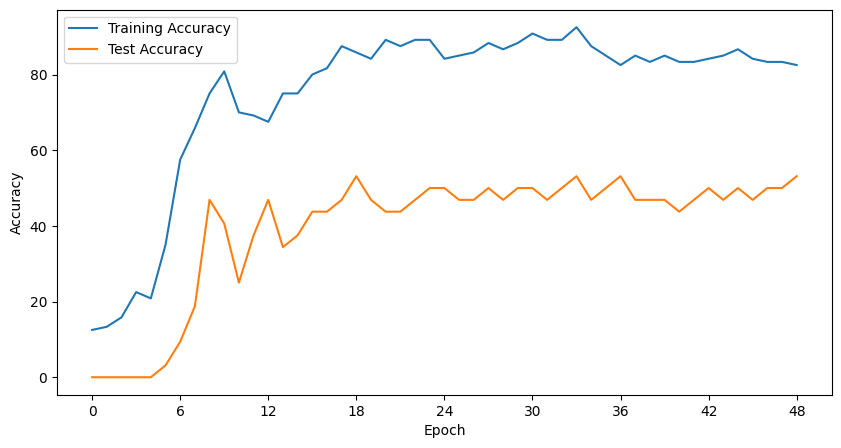

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # make x axis integers
plt.show()

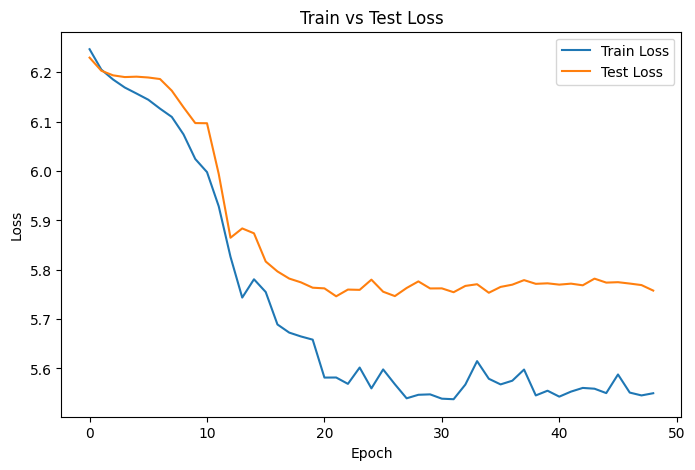

In [11]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()